# Method of Simulated Moments (MSM) for Structural Estimation

### Steps of MSM estimation
1. Load empirical data
2. Define a function to calculate empirical moments from the data
3. Calculate the covariance matrix of the empirical moments (for the weighting matrix)
4. Define a `HARK` agent type with the model parameters to be estimated
5. Define a function to simulate the model and calculate the simulated moments
6. Estimate the model parameters by minimizing the distance between the empirical and simulated moments

In [1]:
from __future__ import annotations

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)


from pathlib import Path

import estimagic as em
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.weightstats import DescrStatsW

figs_dir = Path("../../content/slides/figures/")
figs_dir.mkdir(parents=True, exist_ok=True)

## 1. Load empirical data

In [2]:
scf_data = pd.read_stata("../data/scf_pooled.dta")

scf_data = scf_data[scf_data["age"] >= 26]
scf_data["networththou"] = scf_data["networth"] / 1000
scf_data["wssrinc"] = scf_data["wageinc"] + scf_data["ssretinc"]
scf_data["networthwssrinc"] = scf_data["networth"] / scf_data["wssrinc"]

scf_data = scf_data.replace([np.inf, -np.inf], np.nan)
scf_data = scf_data.dropna()

scf_data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 197277 entries, 56740 to 290734
Columns: 85 entries, wgt to networthwssrinc
dtypes: category(1), float64(35), int8(40), object(9)
memory usage: 75.4+ MB


## 2. Calculate Moments

In [3]:
indices = scf_data["age_lbl"].unique().sort_values()
indices

['(26-30]', '(31-35]', '(36-40]', '(41-45]', '(46-50]', ..., '(71-75]', '(76-80]', '(81-85]', '(86-90]', '(91-95]']
Length: 14
Categories (15, object): ['(21-25]' < '(26-30]' < '(31-35]' < '(36-40]' ... '(76-80]' < '(81-85]' < '(86-90]' < '(91-95]']

In [4]:
def calculate_weighted_median(data, var="networththou", weights="wgt"):
    stats = DescrStatsW(data[var], weights=data[weights])
    return stats.quantile(0.5, return_pandas=False)[0]


def calculate_moments(data, var="networththou", weights="wgt", groupby="age_lbl"):
    medians = data.groupby(groupby, observed=True).apply(
        calculate_weighted_median,
        include_groups=False,
        var=var,
        weights=weights,
    )
    return medians.reindex(indices, fill_value=0.0)

In [5]:
empirical_moments = calculate_moments(scf_data)
empirical_moments.to_pickle("networth_mom.pkl")
print(empirical_moments.to_frame().T)

age_lbl    (26-30]    (31-35]  (36-40]     (41-45]     (46-50]     (51-55]  \
0        26.224575  58.486449  98.9523  142.238501  202.137328  254.618662   

age_lbl     (56-60]     (61-65]     (66-70]     (71-75]  (76-80]     (81-85]  \
0        297.932667  315.878976  340.648307  327.475497  279.517  305.089339   

age_lbl    (86-90]     (91-95]  
0        292.36975  273.808343  


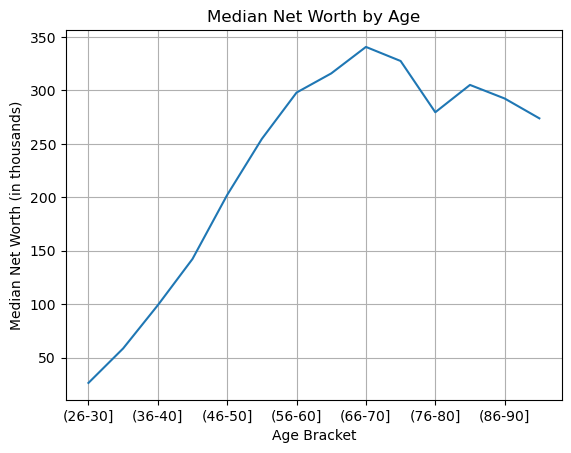

In [6]:
empirical_moments.plot()
plt.title("Median Net Worth by Age")
plt.ylabel("Median Net Worth (in thousands)")
plt.xlabel("Age Bracket")
plt.grid()

## 3. Calculate the covariance matrix of empirical moments

In [7]:
moments_cov = em.get_moments_cov(
    scf_data,
    calculate_moments,
    bootstrap_kwargs={
        "seed": 11323,
        "n_cores": 24,
        "error_handling": "continue",
    },
)

moments_cov.to_pickle("networth_cov.pkl")

moments_cov = pd.read_pickle("networth_cov.pkl")

print(moments_cov)

age_lbl   (26-30]   (31-35]   (36-40]   (41-45]    (46-50]    (51-55]  \
age_lbl                                                                 
(26-30]  1.138775  0.019539  0.064554 -0.030823  -0.052405  -0.159678   
(31-35]  0.019539  2.298721 -0.141000 -0.095465   0.107037  -0.134604   
(36-40]  0.064554 -0.141000  4.188192  0.181477   0.420562   0.107629   
(41-45] -0.030823 -0.095465  0.181477  6.994191   0.282429  -0.549976   
(46-50] -0.052405  0.107037  0.420562  0.282429  10.501479   0.030212   
(51-55] -0.159678 -0.134604  0.107629 -0.549976   0.030212  16.671975   
(56-60]  0.252333 -0.267676 -0.165513 -0.583933   0.216019  -0.167664   
(61-65] -0.217663 -0.229395  0.049796 -1.152797  -0.757894  -0.568752   
(66-70]  0.421039 -0.080862  0.499413  0.100408  -0.560151  -1.817446   
(71-75]  0.039465 -0.021901 -0.850859 -1.240737  -1.725575  -1.414565   
(76-80] -0.215562  0.315986 -0.090836  0.489720   0.149084  -2.091930   
(81-85]  0.147581 -0.134546  0.581648 -0.000474  -0

In [8]:
moments_std = pd.Series(np.sqrt(np.diag(moments_cov)), index=indices)
moments_std

(26-30]     1.067134
(31-35]     1.516153
(36-40]     2.046507
(41-45]     2.644653
(46-50]     3.240599
(51-55]     4.083133
(56-60]     5.456030
(61-65]     6.789076
(66-70]     8.567810
(71-75]     8.333618
(76-80]     5.364945
(81-85]     7.240736
(86-90]    11.988419
(91-95]    14.305564
dtype: float64

In [9]:
moments = pd.DataFrame({"mean": empirical_moments, "std": moments_std})
moments

,mean,std
(26-30],26.224575,1.067134
(31-35],58.486449,1.516153
(36-40],98.952300,2.046507
(41-45],142.238501,2.644653
(46-50],202.137328,3.240599
(51-55],254.618662,4.083133
(56-60],297.932667,5.456030
(61-65],315.878976,6.789076
(66-70],340.648307,8.567810
(71-75],327.475497,8.333618


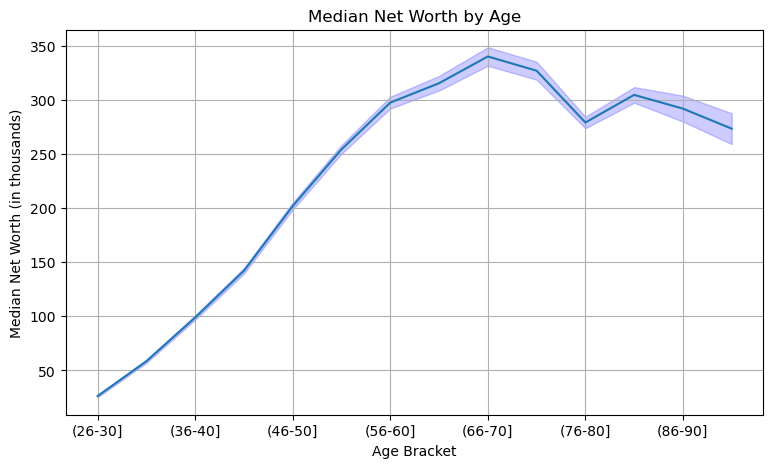

In [10]:
empirical_moments.plot(figsize=(9, 5))

# Add shaded standard deviation
plt.fill_between(
    moments.index,
    moments["mean"] - moments["std"],
    moments["mean"] + moments["std"],
    color="b",
    alpha=0.2,
)

plt.title("Median Net Worth by Age")
plt.ylabel("Median Net Worth (in thousands)")
plt.xlabel("Age Bracket")
plt.grid()

plt.savefig(figs_dir / "median_net_worth_by_age.svg")

In [11]:
medians = scf_data.groupby(["age_lbl", "edcl_lbl"]).apply(
    calculate_weighted_median,
    include_groups=False,
)

moments_by_educ = medians.reset_index().pivot(
    index="age_lbl",
    columns="edcl_lbl",
    values=0,
)

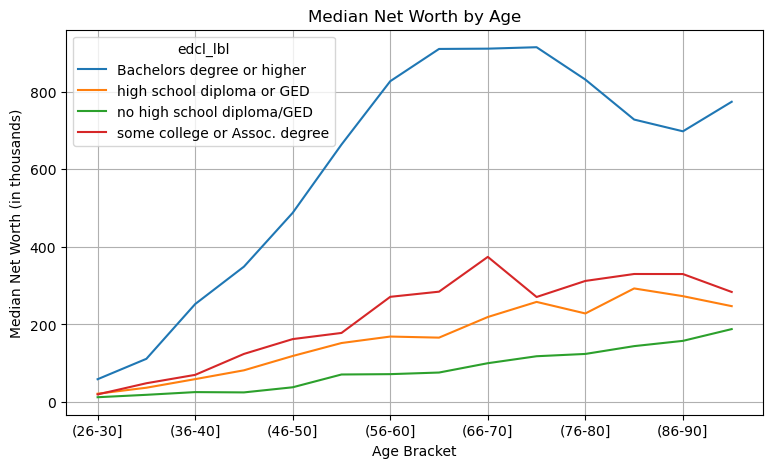

In [12]:
moments_by_educ.plot(figsize=(9, 5))

plt.title("Median Net Worth by Age")
plt.ylabel("Median Net Worth (in thousands)")
plt.xlabel("Age Bracket")
plt.grid()

plt.savefig(figs_dir / "median_net_worth_by_educ.svg")

In [13]:
norm_moments = calculate_moments(scf_data, "networthwssrinc")
norm_moments.to_pickle("norm_networth_mom.pkl")

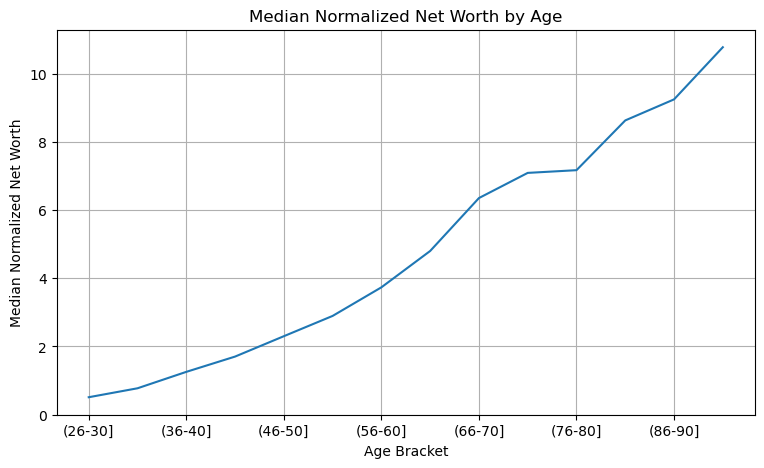

In [14]:
norm_moments.plot(figsize=(9, 5))

plt.title("Median Normalized Net Worth by Age")
plt.ylabel("Median Normalized Net Worth")
plt.xlabel("Age Bracket")
plt.grid()

plt.savefig(figs_dir / "median_norm_net_worth_by_age.svg")

In [16]:
norm_moments_cov = em.get_moments_cov(
    scf_data,
    calculate_moments,
    moment_kwargs={
        "var": "networthwssrinc",
    },
    bootstrap_kwargs={
        "seed": 11323,
        "n_cores": 24,
        "error_handling": "continue",
    },
)

norm_moments_cov.to_pickle("norm_networth_cov.pkl")